In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# tf.enable_eager_execution() #1.X版本下调用
from keras import backend as K
K.set_image_data_format('channels_first')
import os
os.chdir('./4-4/face_recognition/')
import fr_utils
from inception_blocks_v2 import *

Using TensorFlow backend.


In [2]:
FRmodel = faceRecoModel((3,96,96))

In [3]:
FRmodel.count_params()

3743280

In [4]:
FRmodel.summary()

____________________
activation_14 (Activation)      (None, 64, 12, 12)   0           inception_3b_pool_bn[0][0]       
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 64, 12, 12)   0           inception_3b_1x1_bn[0][0]        
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 320, 12, 12)  0           activation_11[0][0]              
                                                                 activation_13[0][0]              
                                                                 activation_14[0][0]              
                                                                 activation_15[0][0]              
__________________________________________________________________________________________________
inception_3c_3x3_conv1 (Conv2D) (None, 128, 12, 12)  41088       concatenate_2[0][0]    

In [5]:
def triplet_loss(y_true, y_pred, alpha=0.2):

    '''
    input:
    y_true - ...keras.losses.[loss_function](y_true, y_pred)
    y_pred - [encode(anchor), encode(positive), encode(negetive)], ~(None,128)
    alpha - margin
    
    output:
    loss - float
    '''

    anchor, positive, negetive = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negetive), axis=-1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))

    return loss

In [6]:
FRmodel.compile(optimizer='adam', loss=triplet_loss, metrics=['accuracy'])
fr_utils.load_weights_from_FaceNet(FRmodel)

In [7]:
database = {}
database["danielle"] = fr_utils.img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = fr_utils.img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = fr_utils.img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = fr_utils.img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = fr_utils.img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = fr_utils.img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = fr_utils.img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = fr_utils.img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = fr_utils.img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = fr_utils.img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = fr_utils.img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = fr_utils.img_to_encoding("images/arnaud.jpg", FRmodel)

### AP**2 - AN**2 + alpha < 0 --> AP**2 < AN**2 - alpha
### loss其实是一个relu方程, 梯度下降后, AP**2 趋近于 AN**2 - alpha (自己跟自己比AP=0)
### 因为我找到的数据Model搭建得有问题, 修改后加载权重, 检查下AP2的值是不是-->0

In [20]:
values = list(database.values())
l = len(values)
n = l * (l-1) / 2
dis1 = values.pop()
AN2 = 0
while values:
    for dis2 in values:
        AN2 += np.linalg.norm(dis1-dis2) ** 2
    dis1 = values.pop()
AN2 /= n
print(AN2)
AP2 = AN2 - 0.2
print(AP2)

0.201384491387015
0.001384491387014991


### Model的修复以及权重应该是对的, 可能我手上的权重在这个数据集上训练过?

In [8]:
def verify(image_path, identity, database, model):
    
    encoding = fr_utils.img_to_encoding(image_path, model)
    dist = np.linalg.norm(encoding - database[identity])
    
    if dist < 0.325:
        print(f'欢迎{identity}回家!')
        is_door_open = True
    else:
        print(f'经验证，您与{identity}不符!')
        is_door_open = False
    
    return dist, is_door_open

In [9]:
verify("images/camera_0.jpg","younes",database,FRmodel)

欢迎younes回家!


(0.32423973, True)

In [49]:
for key in database.keys():
    print(verify("images/sebastiano.jpg", key, database, FRmodel), end='\n\n')    # sebastiano

经验证，您与danielle不符!
(0.5624366, False)

经验证，您与younes不符!
(0.36828777, False)

经验证，您与tian不符!
(0.38994116, False)

欢迎andrew回家!
(0.27591133, True)

经验证，您与kian不符!
(0.3392035, False)

欢迎dan回家!
(0.28138486, True)

欢迎sebastiano回家!
(0.0, True)

欢迎bertrand回家!
(0.30218586, True)

经验证，您与kevin不符!
(0.4250304, False)

经验证，您与felix不符!
(0.42538032, False)

欢迎benoit回家!
(0.23142111, True)

欢迎arnaud回家!
(0.2771502, True)



In [25]:
for key in database.keys():
    print(verify("images/camera_0.jpg", key, database, FRmodel), end='\n\n')    # younes

经验证，您与danielle不符!
(0.617123, False)

欢迎younes回家!
(0.32423973, True)

经验证，您与tian不符!
(0.48727816, False)

经验证，您与andrew不符!
(0.32992446, False)

经验证，您与kian不符!
(0.3939427, False)

经验证，您与dan不符!
(0.34746206, False)

欢迎sebastiano回家!
(0.30868465, True)

经验证，您与bertrand不符!
(0.3634482, False)

经验证，您与kevin不符!
(0.38698474, False)

经验证，您与felix不符!
(0.45550063, False)

经验证，您与benoit不符!
(0.3936328, False)

经验证，您与arnaud不符!
(0.35001203, False)



In [27]:
for key in database.keys():
    print(verify("images/camera_1.jpg", key, database, FRmodel), end='\n\n')    # bertrand

经验证，您与danielle不符!
(0.5641378, False)

经验证，您与younes不符!
(0.34426466, False)

经验证，您与tian不符!
(0.37399986, False)

经验证，您与andrew不符!
(0.35847178, False)

经验证，您与kian不符!
(0.42974773, False)

欢迎dan回家!
(0.26190343, True)

欢迎sebastiano回家!
(0.2213351, True)

欢迎bertrand回家!
(0.22910242, True)

经验证，您与kevin不符!
(0.47475094, False)

经验证，您与felix不符!
(0.45989552, False)

欢迎benoit回家!
(0.30103642, True)

欢迎arnaud回家!
(0.24459057, True)



In [28]:
for key in database.keys():
    print(verify("images/camera_2.jpg", key, database, FRmodel), end='\n\n')    # benoit

经验证，您与danielle不符!
(0.4675689, False)

经验证，您与younes不符!
(0.43912977, False)

欢迎tian回家!
(0.25324932, True)

欢迎andrew回家!
(0.31679255, True)

经验证，您与kian不符!
(0.49157625, False)

经验证，您与dan不符!
(0.42159632, False)

欢迎sebastiano回家!
(0.25349236, True)

经验证，您与bertrand不符!
(0.43376854, False)

经验证，您与kevin不符!
(0.53432614, False)

经验证，您与felix不符!
(0.5363254, False)

欢迎benoit回家!
(0.09048999, True)

经验证，您与arnaud不符!
(0.3472745, False)



In [29]:
for key in database.keys():
    print(verify("images/camera_3.jpg", key, database, FRmodel), end='\n\n')    # bertrand

经验证，您与danielle不符!
(0.72078186, False)

经验证，您与younes不符!
(0.33397698, False)

经验证，您与tian不符!
(0.55072576, False)

经验证，您与andrew不符!
(0.46572307, False)

经验证，您与kian不符!
(0.44936544, False)

欢迎dan回家!
(0.23069167, True)

欢迎sebastiano回家!
(0.3171538, True)

欢迎bertrand回家!
(0.16693412, True)

经验证，您与kevin不符!
(0.49724963, False)

经验证，您与felix不符!
(0.46756756, False)

经验证，您与benoit不符!
(0.46134508, False)

经验证，您与arnaud不符!
(0.32841337, False)



In [30]:
for key in database.keys():
    print(verify("images/camera_4.jpg", key, database, FRmodel), end='\n\n')    # dan

经验证，您与danielle不符!
(0.76115143, False)

经验证，您与younes不符!
(0.43558702, False)

经验证，您与tian不符!
(0.54397774, False)

经验证，您与andrew不符!
(0.45019233, False)

经验证，您与kian不符!
(0.431624, False)

欢迎dan回家!
(0.12684041, True)

欢迎sebastiano回家!
(0.30261102, True)

欢迎bertrand回家!
(0.24072503, True)

经验证，您与kevin不符!
(0.5127149, False)

经验证，您与felix不符!
(0.39603367, False)

经验证，您与benoit不符!
(0.45432562, False)

欢迎arnaud回家!
(0.30753192, True)



In [31]:
for key in database.keys():
    print(verify("images/camera_5.jpg", key, database, FRmodel), end='\n\n')    # arnaud

经验证，您与danielle不符!
(0.6422861, False)

欢迎younes回家!
(0.30143508, True)

经验证，您与tian不符!
(0.4713883, False)

经验证，您与andrew不符!
(0.36980096, False)

经验证，您与kian不符!
(0.35285145, False)

欢迎dan回家!
(0.25420874, True)

欢迎sebastiano回家!
(0.25168005, True)

欢迎bertrand回家!
(0.27581146, True)

经验证，您与kevin不符!
(0.41460294, False)

经验证，您与felix不符!
(0.42046443, False)

经验证，您与benoit不符!
(0.38087374, False)

欢迎arnaud回家!
(0.2952794, True)



### 这个面部验证系统还不够robust, 阈值很难选, 为了没人被拒之门外, 这里选了0.325, 但放进来了很多错误的人

In [57]:
def who_is_it(image_path, database, model):
    
    encoding = fr_utils.img_to_encoding(image_path, model)
    min_dist = None
    for (key, value) in database.items():
        dist = np.linalg.norm(encoding - value)
        if (min_dist == None) or (dist < min_dist):
            min_dist = dist
            identity = key

    if min_dist < 0.325:
        print(f'欢迎{identity}回家!')
    else:
        print(f'抱歉, 您的信息不在数据库中!')
    
    return min_dist, identity


In [58]:
print(who_is_it("images/camera_5.jpg", database, FRmodel), end='\n\n')    # arnaud

欢迎sebastiano回家!
(0.25168005, 'sebastiano')



In [59]:
print(who_is_it("images/camera_4.jpg", database, FRmodel), end='\n\n')    # dan

欢迎dan回家!
(0.12684041, 'dan')



In [60]:
print(who_is_it("images/camera_3.jpg", database, FRmodel), end='\n\n')    # bertrand

欢迎bertrand回家!
(0.16693412, 'bertrand')



In [61]:
print(who_is_it("images/camera_2.jpg", database, FRmodel), end='\n\n')    # benoit

欢迎benoit回家!
(0.09048999, 'benoit')



In [62]:
print(who_is_it("images/camera_1.jpg", database, FRmodel), end='\n\n')    # bertrand

欢迎sebastiano回家!
(0.2213351, 'sebastiano')



In [63]:
print(who_is_it("images/camera_0.jpg", database, FRmodel), end='\n\n')    # younes

欢迎sebastiano回家!
(0.30868465, 'sebastiano')



### 可以看出效果不太理想, sebastiano比较搞事情, 打印出来看看

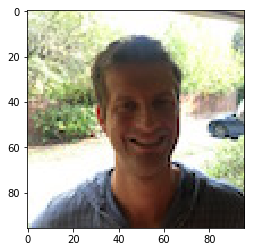

In [47]:
image_path = './images/sebastiano.jpg'
from imageio import imread
image = imread(image_path)
plt.imshow(image)